In [50]:
from pathlib import Path
import pandas as pd
import pydicom
from matplotlib import pyplot as plt
from ipywidgets import interact
import numpy as np
from skimage.io import imsave

In [53]:
print(f'pydicom=={pydicom.__version__}')
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
import ipywidgets
print(f'ipywidgets=={ipywidgets.__version__}')
import skimage
print(f'skimage=={skimage.__version__}')
import matplotlib
print(f'matplotlib=={matplotlib.__version__}')

pydicom==2.3.0
numpy==1.23.2
pandas==1.4.4
ipywidgets==8.0.2
skimage==0.19.3
matplotlib==3.5.3


## Get the necessary paths

Read only files

In [2]:
project_path = Path.cwd().parent
data_path = project_path/'data'
dicom_path = data_path/'dicom'
dicom_files = list(dicom_path.glob('*.dcm'))

CSV files from Vinod

In [54]:
train_csv = data_path/'processed/csv/train_patients.csv'
valid_csv = data_path/'processed/csv/valid_patients.csv'
test_csv = data_path/'processed/csv/test_patients.csv'
modalities_csv = data_path/'processed/csv/modalities.csv'

Directories to save processed MRI images

In [39]:
mri_png_dir = data_path/'processed/mri'

## Train-val-test splits processing

In [3]:
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(valid_csv)
test_df = pd.read_csv(test_csv)
train_df.head()

,indx,patient,birthdate,heart_failure,heart_failure_age,coronary_heart,coronary_heart_age,myocardial_infarction,myocardial_infarction_age,stroke,stroke_age,cardiac_arrest,cardiac_arrest_age
0,0,c2a58661-9352-1929-fc29-c51fad4c6950,1917-01-11,True,52.0,False,NaN,False,NaN,False,NaN,False,NaN
1,1,adf80417-f70b-2fe8-a2da-0fdcf70b2509,1912-10-03,False,NaN,True,80.0,False,NaN,True,94.0,False,NaN
2,2,6cb86432-5f9e-6f74-2289-a8295e84c64e,1933-08-06,False,NaN,True,73.0,False,NaN,True,78.0,False,NaN
3,3,b8e7ebe2-ef2c-5562-7390-e216389cdba8,1924-08-15,False,NaN,True,86.0,False,NaN,True,41.0,False,NaN
4,4,fbb75ebb-8b10-2a28-5634-3b8f4da7442b,1939-08-12,True,80.0,True,61.0,False,NaN,False,NaN,False,NaN


In [4]:
print(f'there are {len(train_df)} patients in the train split')
print(f'there are {len(val_df)} patients in the validation split')
print(f'there are {len(test_df)} patients in the test split')

there are 766 patients in the train split
there are 256 patients in the validation split
there are 256 patients in the test split


Description of the splits in more details
```
Train: 766, Valid: 256, Test: 256 -- Total before split: 1278

Train:
{'heart_failure': 189,
  'coronary_heart': 194,
  'myocardial_infarction': 82,
  'stroke': 435,
  'cardiac_arrest': 107},

Valid:
 {'heart_failure': 68,
  'coronary_heart': 66,
  'myocardial_infarction': 28,
  'stroke': 138,
  'cardiac_arrest': 30},

Test:
 {'heart_failure': 75,
  'coronary_heart': 76,
  'myocardial_infarction': 35,
  'stroke': 125,
  'cardiac_arrest': 43}
```

In [5]:
train_patient_ids = list(train_df['patient'])
val_patient_ids = list(val_df['patient'])
test_patient_ids = list(test_df['patient'])

In [6]:
print(f' there are {len(dicom_files)} MRI scans in total')

 there are 298 MRI scans in total


Get the patient ids from dicom file names

An example dicom file has the name `Charlette938_Runolfsson901_e8116fd7-c1a4-ddca-c425-6c63cb9ab2ec1.2.840.99999999.73920120.1192398818819.dcm`, where: 
- `Charlette938_Runolfsson901` is the patient name
- `e8116fd7-c1a4-ddca-c425-6c63cb9ab2ec` is the patient id
- `1.2.840.99999999.73920120.1192398818819` is the imaging study id (we don't have to care)

In [7]:
dicom_patient_ids = []
dicom_patient_ids_paths = []  # keeps the patient id and corresponding mri file path

for i, file_path in enumerate(dicom_files):  
    s = str(file_path.name).split('_')[2]
    id = s.split('1.2.')[0]
    dicom_patient_ids.append(id)
    dicom_patient_ids_paths.append((id, file_path))

print(f' there are {len(dicom_patient_ids)} MRI scans in total')

 there are 298 MRI scans in total


In [8]:
df_patient_mri = pd.DataFrame(dicom_patient_ids_paths, columns =['patient', 'mri_file_path'])

In [9]:
train_dicom_ids = set(dicom_patient_ids).intersection(set(train_patient_ids))
val_dicom_ids = set(dicom_patient_ids).intersection(set(val_patient_ids))
test_dicom_ids = set(dicom_patient_ids).intersection(set(test_patient_ids))
print(f' there are {len(train_dicom_ids)} patients with MRI scans in the train split')
print(f' there are {len(val_dicom_ids)} patients with MRI scans in the validation split')
print(f' there are {len(test_dicom_ids)} patients with MRI scans in the test split')

 there are 178 patients with MRI scans in the train split
 there are 62 patients with MRI scans in the validation split
 there are 57 patients with MRI scans in the test split


Append the MRI file paths to the train, val and test dataframes

In [10]:
train_df['mri_file_path'] = '' * len(train_df)
val_df['mri_file_path'] = '' * len(val_df)
test_df['mri_file_path'] = '' * len(test_df)

In [11]:
train_mri_df = pd.merge(df_patient_mri, train_df, on="patient")
val_mri_df = pd.merge(df_patient_mri, val_df, on="patient")
test_mri_df = pd.merge(df_patient_mri, test_df, on="patient")

In [12]:
print(len(train_mri_df))
train_mri_df.head(5)

178


,patient,mri_file_path_x,indx,birthdate,heart_failure,heart_failure_age,coronary_heart,coronary_heart_age,myocardial_infarction,myocardial_infarction_age,stroke,stroke_age,cardiac_arrest,cardiac_arrest_age,mri_file_path_y
0,e8116fd7-c1a4-ddca-c425-6c63cb9ab2ec,/home/dk/Desktop/projects/multimodal-healthcar...,559,1927-10-17,False,NaN,False,NaN,False,NaN,True,79.0,False,NaN,
1,143ae8e8-5c70-bd3b-c37d-27d8599f5aa3,/home/dk/Desktop/projects/multimodal-healthcar...,520,1936-06-05,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,
2,c9f4ee85-7e93-e0d0-3342-d5c794e825ff,/home/dk/Desktop/projects/multimodal-healthcar...,673,1932-04-29,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,
3,17a023c2-aa70-4c0a-a9e8-43b4a10654d1,/home/dk/Desktop/projects/multimodal-healthcar...,135,1912-02-02,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,
4,9f22bcfc-cbd6-5da5-c46b-050275e8be1e,/home/dk/Desktop/projects/multimodal-healthcar...,491,1938-10-27,False,NaN,False,NaN,False,NaN,True,74.0,False,NaN,


In [13]:
print(len(val_mri_df))
val_mri_df.head(2)

62


,patient,mri_file_path_x,indx,birthdate,heart_failure,heart_failure_age,coronary_heart,coronary_heart_age,myocardial_infarction,myocardial_infarction_age,stroke,stroke_age,cardiac_arrest,cardiac_arrest_age,mri_file_path_y
0,ba9485fd-fcee-dace-0843-b8894ad33b8f,/home/dk/Desktop/projects/multimodal-healthcar...,137,1913-09-08,False,NaN,True,81.0,False,NaN,True,96.0,True,86.0,
1,94938ad3-7ba9-dc6e-0948-714bc1f29546,/home/dk/Desktop/projects/multimodal-healthcar...,0,1933-10-11,False,NaN,False,NaN,False,NaN,True,59.0,False,NaN,


In [14]:
print(len(test_mri_df))
test_mri_df.head(2)

57


,patient,mri_file_path_x,indx,birthdate,heart_failure,heart_failure_age,coronary_heart,coronary_heart_age,myocardial_infarction,myocardial_infarction_age,stroke,stroke_age,cardiac_arrest,cardiac_arrest_age,mri_file_path_y
0,6587b036-1716-539b-88de-c4198ff108ba,/home/dk/Desktop/projects/multimodal-healthcar...,244,1914-10-29,False,NaN,False,NaN,False,NaN,True,68.0,False,NaN,
1,aee205cf-57bc-a73a-0820-52aa481986c6,/home/dk/Desktop/projects/multimodal-healthcar...,73,1915-07-14,False,NaN,True,69.0,True,89.0,True,77.0,False,NaN,


## Explore MRI data

Let's explore one MRI image

In [22]:
dicom_file = dicom_files[0]
try:
    dcm = pydicom.dcmread(dicom_file)
    print(type(dcm))
except FileNotFoundError:
    print ('error during file read ', dicom_file)
    
# convert DICOM into numerical numpy array of pixel intensity values
img = dcm.pixel_array
print(f'img shape: {img.shape}')

<class 'pydicom.dataset.FileDataset'>
img shape: (256, 256, 256)


In [23]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(5, 3))
    channel = 0
    plt.imshow(img[:, :, layer]);
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data among the depth dimension
interact(explore_3dimage, layer=(0, img.shape[2] - 1));

interactive(children=(IntSlider(value=127, description='layer', max=255), Output()), _dom_classes=('widget-int…

Pick only slices from 70 - 185

In [24]:
# convert uint16 datatype to float, scaled properly for uint8
img = img.astype(float) * 255. / img.max()
# convert from float -> uint8
img = img.astype(np.uint8)
img = img[:, :, 70:185]
# save final .png
# imsave(png_path, img)

In [25]:
interact(explore_3dimage, layer=(0, img.shape[2] - 1));

interactive(children=(IntSlider(value=57, description='layer', max=114), Output()), _dom_classes=('widget-inte…

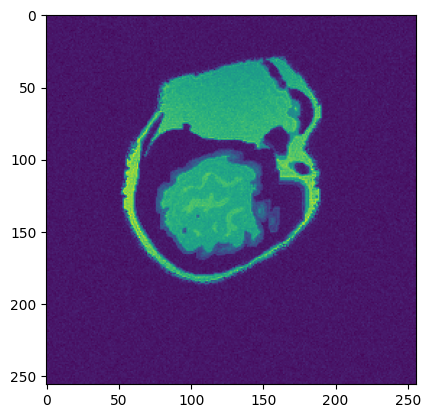

In [27]:
img
plt.imshow(img[:, :, 0])

## MRI Data Processing

For each patient, read his/her MRI image, discard noisy slices and save all the useful slices as `.png` files into `mri_png_dir`. The names of the `.png` images are determined by the patient's id

In [40]:
print(f'save MRI png images to {mri_png_dir}')
if not mri_png_dir.exists():
    mri_png_dir.mkdir()

save MRI png images to /home/dk/Desktop/projects/multimodal-healthcare/mri/data/processed/mri


Utility functions

In [44]:
def read_convert_dcm(mri_path: Path) -> np.ndarray:
    """
    Read a dicom file into an MRI volume, then scale it and pick only slices that contain
    the brain
    """
    dcm = pydicom.dcmread(mri_path)
    mri_volume = dcm.pixel_array
    # convert uint16 datatype to float, scaled properly for uint8
    mri_volume = mri_volume.astype(float) * 255. / mri_volume.max()
    # convert from float to uint8
    mri_volume = mri_volume.astype(np.uint8)
    # only pick slices that contain the brain
    mri_volume = mri_volume[:, :, 70:185]
    
    return mri_volume

def save_mri_volume(mri_vol: np.ndarray, output_path: Path):
    """
    Save each slice of the mri volume into a separate image
    """
    for slice_idx in range(mri_vol.shape[2]):
        slice_output_path = str(output_path) + f'_{slice_idx}' + '.png'
        mri_slice = mri_vol[:, :, slice_idx]
        imsave(slice_output_path, mri_slice)

def mri_processing(df: pd.DataFrame, output_dir: Path):
    """
    Take a dataframe, e.g. train_mri_df, loop through each patient, process his corresponding
    MRI scan and save the slices into .png images with names according to his id
    """
    for index, row in df.iterrows():
        id = row['patient']
        mri_path = row['mri_file_path_x']
        mri_volume = read_convert_dcm(mri_path)
        output_path = output_dir/id
        save_mri_volume(mri_volume, output_path)

Training MRI image processing

In [ ]:
train_mri_png_dir = mri_png_dir/'train'
train_mri_png_dir.mkdir()
mri_processing(train_mri_df, train_mri_png_dir)

Validation MRI image processing

In [47]:
val_mri_png_dir = mri_png_dir/'val'
val_mri_png_dir.mkdir()
mri_processing(val_mri_df, val_mri_png_dir)

Test MRI image processing

In [48]:
test_mri_png_dir = mri_png_dir/'test'
test_mri_png_dir.mkdir()
mri_processing(test_mri_df, test_mri_png_dir)

## Resources

https://github.com/mazurowski-lab/MRI-deeplearning-tutorial